In [1]:
%matplotlib inline
import os
import time
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import scipy.io
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import scipy.misc

from darknet import Darknet
import dataset
from utils import *
from MeshPly import MeshPly
from PIL import Image

# Create new directory
def makedirs(path):
    if not os.path.exists( path ):
        os.makedirs( path )

[[-2.38712010e+01 -2.38712010e+01 -2.38712010e+01 -2.38712010e+01
   2.38712010e+01  2.38712010e+01  2.38712010e+01  2.38712010e+01]
 [-1.20620003e+02 -1.20620003e+02  5.00000000e-06  5.00000000e-06
  -1.20620003e+02 -1.20620003e+02  5.00000000e-06  5.00000000e-06]
 [-2.14025000e+01  2.14025000e+01 -2.14025000e+01  2.14025000e+01
  -2.14025000e+01  2.14025000e+01 -2.14025000e+01  2.14025000e+01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64
    4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    5 conv     64  1 x 1 / 1   104 x 104 x 128   -

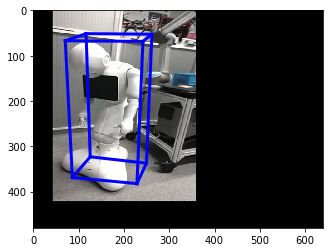

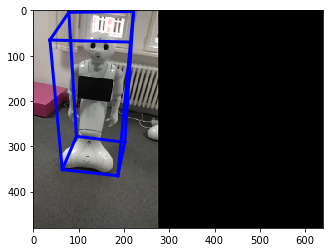

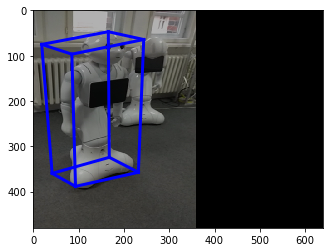

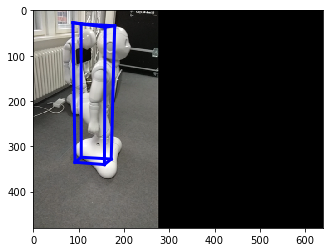

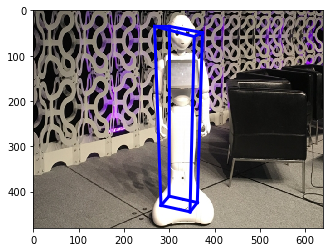

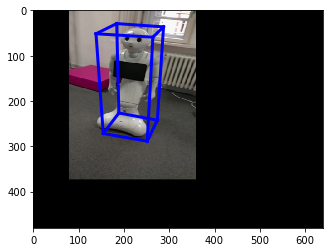

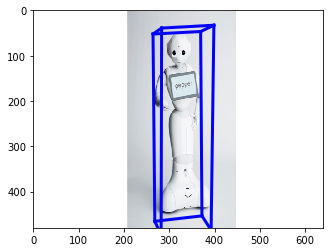

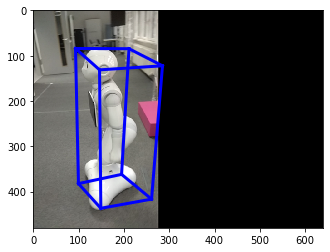

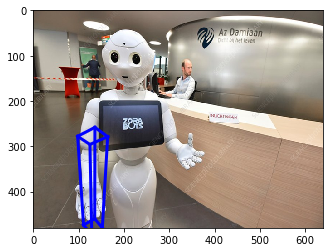

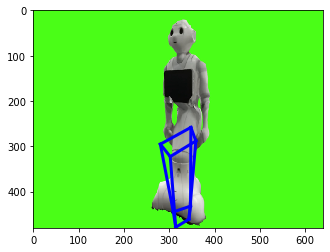

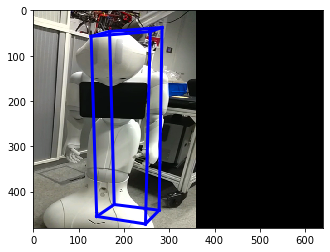

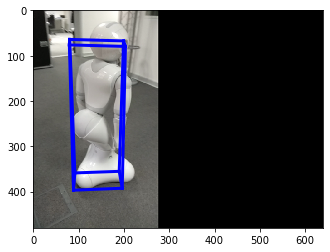

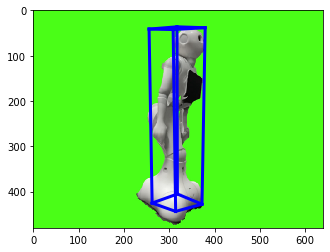

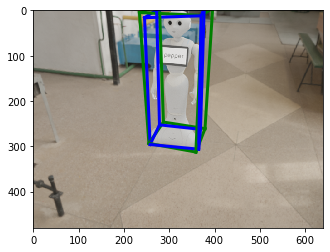

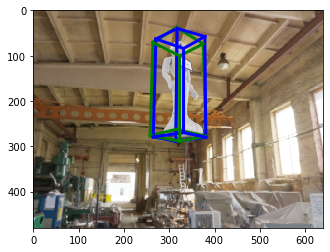

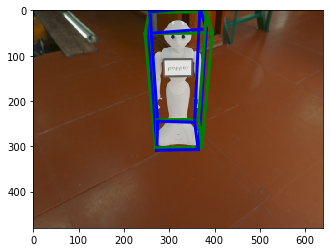

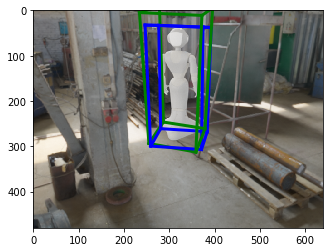

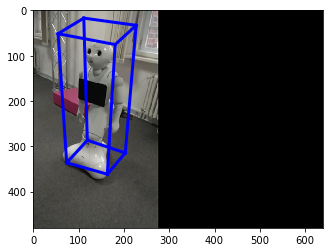

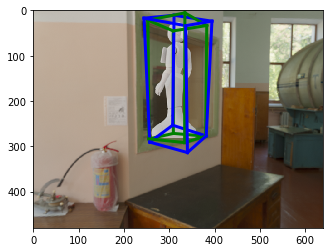

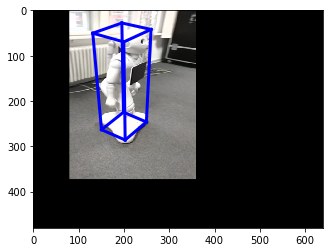

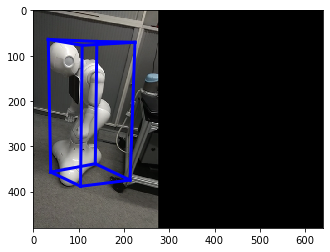

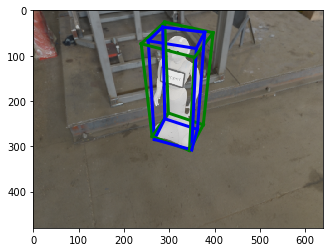

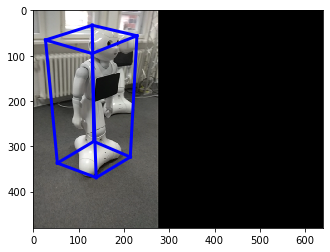

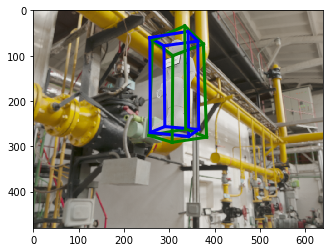

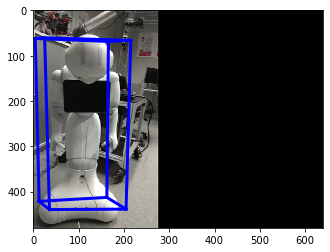

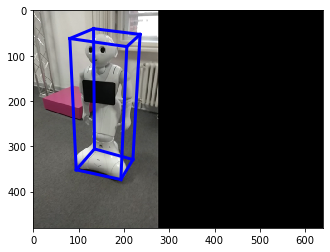

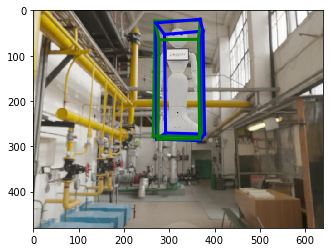

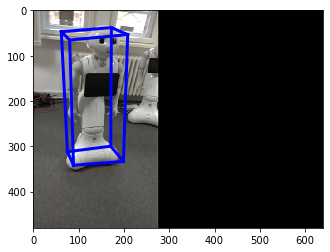

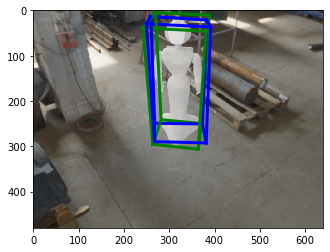

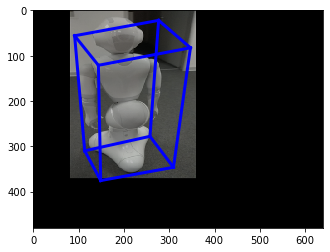

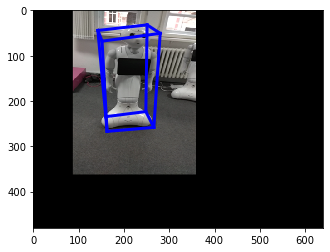

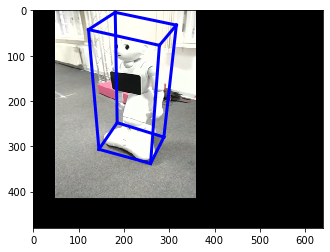

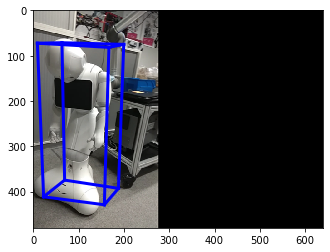

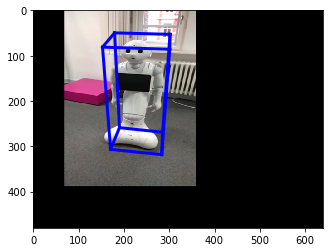

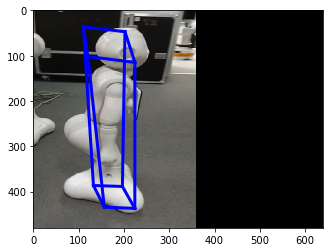

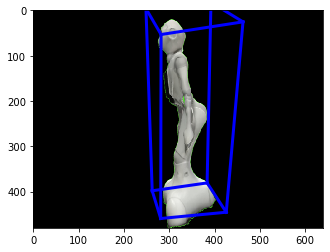

-----------------------------------
  tensor to cuda : 0.000449
         predict : 0.004289
get_region_boxes : 0.029027
             nms : 0.361823
           total : 0.395588
-----------------------------------
2021-04-21 00:20:34 Results of pepper_test
2021-04-21 00:20:34    Acc using 5 px 2D Projection = 5.56%
2021-04-21 00:20:34    Acc using the IoU metric = 99.999972%
2021-04-21 00:20:34    Acc using 10% threshold - 0.06 vx 3D Transformation = 0.00%
2021-04-21 00:20:34    Acc using 5 cm 5 degree metric = 0.00%
2021-04-21 00:20:34    Mean 2D pixel error is 2930.472412, Mean vertex error is 16180624.363637, mean corner error is 407.407623
2021-04-21 00:20:34    Translation error: 16180568.256340 m, angle error: 113.425637 degree, pixel error:  2930.472511 pix


In [3]:
def valid(datacfg, cfgfile, weightfile):
    def truths_length(truths):
        for i in range(50):
            if truths[i][1] == 0:
                return i

    # Parse configuration files
    options      = read_data_cfg(datacfg)
    valid_images = options['valid']
    meshname     = options['mesh']
    backupdir    = options['backup']
    name         = options['name']
    if not os.path.exists(backupdir):
        makedirs(backupdir)

    # Parameters
    prefix       = 'results'
    seed         = int(time.time())
    gpus         = '0'     # Specify which gpus to use
    test_width   = 544
    test_height  = 544
    torch.manual_seed(seed)
    use_cuda = True
    if use_cuda:
        os.environ['CUDA_VISIBLE_DEVICES'] = gpus
        torch.cuda.manual_seed(seed)
    save            = False
    visualize       = True
    testtime        = True
    use_cuda        = True
    num_classes     = 1
    testing_samples = 0.0
    eps             = 1e-5
    notpredicted    = 0 
    conf_thresh     = 0.1
    nms_thresh      = 0.4
    match_thresh    = 0.5
    edges_corners = [[0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6], [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]]

    if save:
        makedirs(backupdir + '/test')
        makedirs(backupdir + '/test/gt')
        makedirs(backupdir + '/test/pr')

    # To save
    testing_error_trans = 0.0
    testing_error_angle = 0.0
    testing_error_pixel = 0.0
    errs_2d             = []
    errs_3d             = []
    errs_trans          = []
    errs_angle          = []
    errs_corner2D       = []
    preds_trans         = []
    preds_rot           = []
    preds_corners2D     = []
    gts_trans           = []
    gts_rot             = []
    gts_corners2D       = []
    ious                = []

    # Read object model information, get 3D bounding box corners
    mesh          = MeshPly(meshname)
    vertices      = np.c_[np.array(mesh.vertices), np.ones((len(mesh.vertices), 1))].transpose()
    corners3D     = get_3D_corners(vertices)
    print(corners3D)
    # diam          = calc_pts_diameter(np.array(mesh.vertices))
    diam          = float(options['diam'])

    # Read intrinsic camera parameters
    internal_calibration = get_camera_intrinsic()

    # Get validation file names
    with open(valid_images) as fp:
        tmp_files = fp.readlines()
        valid_files = [item.rstrip() for item in tmp_files]
    
    # Specicy model, load pretrained weights, pass to GPU and set the module in evaluation mode
    model = Darknet(cfgfile)
    model.print_network()
    model.load_weights(weightfile)
    model.cuda()
    model.eval()

    # Get the parser for the test dataset
    valid_dataset = dataset.listDataset(valid_images, shape=(test_width, test_height),
                       shuffle=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),]))
    valid_batchsize = 1

    # Specify the number of workers for multiple processing, get the dataloader for the test dataset
    kwargs = {'num_workers': 4, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_batchsize, shuffle=False, **kwargs) 

    logging("   Testing {}...".format(name))
    logging("   Number of test samples: %d" % len(test_loader.dataset))
    # Iterate through test batches (Batch size for test data is 1)
    count = 0
    z = np.zeros((3, 1))
    for batch_idx, (data, target) in enumerate(test_loader):
        
        # Images
        img = data[0, :, :, :]
        img = img.numpy().squeeze()
        img = np.transpose(img, (1, 2, 0))
        
        t1 = time.time()
        # Pass data to GPU
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        
        # Wrap tensors in Variable class, set volatile=True for inference mode and to use minimal memory during inference
        data = Variable(data, volatile=True)
        t2 = time.time()
        
        # Forward pass
        output = model(data).data  
        t3 = time.time()
        
        # Using confidence threshold, eliminate low-confidence predictions
        all_boxes = get_region_boxes(output, conf_thresh, num_classes)        
        t4 = time.time()

        # Iterate through all images in the batch
        for i in range(output.size(0)):
        
            # For each image, get all the predictions
            boxes   = all_boxes[i]
        
            # For each image, get all the targets (for multiple object pose estimation, there might be more than 1 target per image)
            truths  = target[i].view(-1, 21)
        
            # Get how many object are present in the scene
            num_gts = truths_length(truths)

             # Iterate through each ground-truth object
            for k in range(num_gts):
                box_gt        = [truths[k][1], truths[k][2], truths[k][3], truths[k][4], truths[k][5], truths[k][6], 
                                truths[k][7], truths[k][8], truths[k][9], truths[k][10], truths[k][11], truths[k][12], 
                                truths[k][13], truths[k][14], truths[k][15], truths[k][16], truths[k][17], truths[k][18], 1.0, 1.0, truths[k][0]]
                best_conf_est = -1

                # If the prediction has the highest confidence, choose it as our prediction for single object pose estimation
                for j in range(len(boxes)):
                    if (boxes[j][18] > best_conf_est):
                        match         = corner_confidence9(box_gt[:18], torch.FloatTensor(boxes[j][:18]))
                        box_pr        = boxes[j]
                        best_conf_est = boxes[j][18]

                # Denormalize the corner predictions 
                corners2D_gt = np.array(np.reshape(box_gt[:18], [9, 2]), dtype='float32')
                corners2D_pr = np.array(np.reshape(box_pr[:18], [9, 2]), dtype='float32')
                corners2D_gt[:, 0] = corners2D_gt[:, 0] * 640
                corners2D_gt[:, 1] = corners2D_gt[:, 1] * 480
                corners2D_pr[:, 0] = corners2D_pr[:, 0] * 640
                corners2D_pr[:, 1] = corners2D_pr[:, 1] * 480
                preds_corners2D.append(corners2D_pr)
                gts_corners2D.append(corners2D_gt)

                # Compute corner prediction error
                corner_norm = np.linalg.norm(corners2D_gt - corners2D_pr, axis=1)
                corner_dist = np.mean(corner_norm)
                errs_corner2D.append(corner_dist)
                
                # Compute [R|t] by pnp
                R_gt, t_gt = pnp(np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)), dtype='float32'),  corners2D_gt, np.array(internal_calibration, dtype='float32'))
                R_pr, t_pr = pnp(np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)), dtype='float32'),  corners2D_pr, np.array(internal_calibration, dtype='float32'))

                if save:
                    preds_trans.append(t_pr)
                    gts_trans.append(t_gt)
                    preds_rot.append(R_pr)
                    gts_rot.append(R_gt)

                    np.savetxt(backupdir + '/test/gt/R_' + valid_files[count][-8:-3] + 'txt', np.array(R_gt, dtype='float32'))
                    np.savetxt(backupdir + '/test/gt/t_' + valid_files[count][-8:-3] + 'txt', np.array(R_pr, dtype='float32'))
                    np.savetxt(backupdir + '/test/pr/R_' + valid_files[count][-8:-3] + 'txt', np.array(t_gt, dtype='float32'))
                    np.savetxt(backupdir + '/test/pr/t_' + valid_files[count][-8:-3] + 'txt', np.array(t_pr, dtype='float32'))
                    np.savetxt(backupdir + '/test/gt/corners_' + valid_files[count][-8:-3] + 'txt', np.array(corners2D_gt, dtype='float32'))
                    np.savetxt(backupdir + '/test/pr/corners_' + valid_files[count][-8:-3] + 'txt', np.array(corners2D_pr, dtype='float32'))
                
                # Compute translation error
                trans_dist   = np.sqrt(np.sum(np.square(t_gt - t_pr)))
                errs_trans.append(trans_dist)
                
                # Compute angle error
                angle_dist   = calcAngularDistance(R_gt, R_pr)
                errs_angle.append(angle_dist)
                
                # Compute pixel error
                Rt_gt        = np.concatenate((R_gt, t_gt), axis=1)
                Rt_pr        = np.concatenate((R_pr, t_pr), axis=1)
                proj_2d_gt   = compute_projection(vertices, Rt_gt, internal_calibration)
                proj_2d_pred = compute_projection(vertices, Rt_pr, internal_calibration)  
                proj_corners_gt = np.transpose(compute_projection(corners3D, Rt_gt, internal_calibration)) 
                proj_corners_pr = np.transpose(compute_projection(corners3D, Rt_pr, internal_calibration)) 
                norm         = np.linalg.norm(proj_2d_gt - proj_2d_pred, axis=0)
                pixel_dist   = np.mean(norm)
                errs_2d.append(pixel_dist)

                if visualize:
                    # Visualize
                    plt.xlim((0, 640))
                    plt.ylim((0, 480))
                    plt.imshow( np.array(Image.fromarray((img*255).astype(np.uint8)).resize(size=(640, 480))))
                    # Projections
                    #for edge in edges_corners2d:
                        #plt.plot(gts_corners2D[edge, 0], gts_corners2D[edge, 1], color='g', linewidth=3.0)
                        #plt.plot(preds_corners2D[edge, 0], preds_corners2D[edge, 1], color='b', linewidth=3.0)#
                    #plt.gca().invert_yaxis()
                    #plt.show()
                    
                    edges_corners2d = [[1, 2], [1, 3], [1, 5], [2, 4], [2, 6], [3, 4], [3, 7], [4, 8], [5, 6], [5, 7], [6, 8], [7, 8]]
                    for edge in edges_corners2d:         
                        #print(edge)
                        #print(gts_corners2D)
                        #print(preds_corners2D)
                        plt.plot( [corners2D_gt[edge[0]][0],corners2D_gt[edge[1]][0]], [corners2D_gt[edge[0]][1],corners2D_gt[edge[1]][1]], color='g', linewidth=3.0)
                        plt.plot( [corners2D_pr[edge[0]][0],corners2D_pr[edge[1]][0]], [corners2D_pr[edge[0]][1],corners2D_pr[edge[1]][1]], color='b', linewidth=3.0)
                    plt.gca().invert_yaxis()
                    plt.savefig(backupdir + '/test/comparison/comparison_{}png'.format(valid_files[count][-8:-3]), bbox_inches='tight')
                    plt.show()
                
                # Compute IoU score
                bb_gt        = compute_2d_bb_from_orig_pix(proj_2d_gt, output.size(3))
                bb_pred      = compute_2d_bb_from_orig_pix(proj_2d_pred, output.size(3))
                iou          = bbox_iou(bb_gt, bb_pred)
                ious.append(iou)

                # Compute 3D distances
                transform_3d_gt   = compute_transformation(vertices, Rt_gt) 
                transform_3d_pred = compute_transformation(vertices, Rt_pr)  
                norm3d            = np.linalg.norm(transform_3d_gt - transform_3d_pred, axis=0)
                vertex_dist       = np.mean(norm3d)    
                errs_3d.append(vertex_dist)  

                # Sum errors
                testing_error_trans  += trans_dist
                testing_error_angle  += angle_dist
                testing_error_pixel  += pixel_dist
                testing_samples      += 1
                count = count + 1

        t5 = time.time()

    # Compute 2D projection error, 6D pose error, 5cm5degree error
    px_threshold = 5
    acc         = len(np.where(np.array(errs_2d) <= px_threshold)[0]) * 100. / (len(errs_2d)+eps)
    acciou      = len(np.where(np.array(errs_2d) >= 0.5)[0]) * 100. / (len(ious)+eps)
    acc5cm5deg  = len(np.where((np.array(errs_trans) <= 0.05) & (np.array(errs_angle) <= 5))[0]) * 100. / (len(errs_trans)+eps)
    acc3d10     = len(np.where(np.array(errs_3d) <= diam * 0.1)[0]) * 100. / (len(errs_3d)+eps)
    acc5cm5deg  = len(np.where((np.array(errs_trans) <= 0.05) & (np.array(errs_angle) <= 5))[0]) * 100. / (len(errs_trans)+eps)
    corner_acc  = len(np.where(np.array(errs_corner2D) <= px_threshold)[0]) * 100. / (len(errs_corner2D)+eps)
    mean_err_2d = np.mean(errs_2d)
    mean_corner_err_2d = np.mean(errs_corner2D)
    nts = float(testing_samples)

    if testtime:
        print('-----------------------------------')
        print('  tensor to cuda : %f' % (t2 - t1))
        print('         predict : %f' % (t3 - t2))
        print('get_region_boxes : %f' % (t4 - t3))
        print('             nms : %f' % (t5 - t4))
        print('           total : %f' % (t5 - t1))
        print('-----------------------------------')

    # Print test statistics
    logging('Results of {}'.format(name))
    logging('   Acc using {} px 2D Projection = {:.2f}%'.format(px_threshold, acc))
    logging('   Acc using the IoU metric = {:.6f}%'.format(acciou))
    logging('   Acc using 10% threshold - {} vx 3D Transformation = {:.2f}%'.format(diam * 0.1, acc3d10))
    logging('   Acc using 5 cm 5 degree metric = {:.2f}%'.format(acc5cm5deg))
    logging("   Mean 2D pixel error is %f, Mean vertex error is %f, mean corner error is %f" % (mean_err_2d, np.mean(errs_3d), mean_corner_err_2d))
    logging('   Translation error: %f m, angle error: %f degree, pixel error: % f pix' % (testing_error_trans/nts, testing_error_angle/nts, testing_error_pixel/nts) )

    if save:
        predfile = backupdir + '/predictions_linemod_' + name +  '.mat'
        scipy.io.savemat(predfile, {'R_gts': gts_rot, 't_gts':gts_trans, 'corner_gts': gts_corners2D, 'R_prs': preds_rot, 't_prs':preds_trans, 'corner_prs': preds_corners2D})

datacfg = 'pepper_robot.data'#'test_images.data'
cfgfile = 'yolo-pose.cfg'
weightfile = 'backup/model_mixed.weights'
valid(datacfg, cfgfile, weightfile)